<a href="https://colab.research.google.com/github/dsgustavomoreira/RNN-Previsao-de-Demanda/blob/main/RNN_S%C3%A9ries_Temporais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RNN - Séries Temporais com LSTM**



# **1 - Problema de Negócio**

Previsão de demanda de Produtos das Lojas

Base de Dados utilizado para o case: https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data

# **2 - Importação das bibliotecas**

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import zipfile
import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import ParameterGrid


# **3 - Conexão com a Base de Dados**

In [ ]:
# Configuração da API do Kaggle
!mkdir -p ~/.Kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Instação da API do Kaggle e upload da base de dados
!kaggle competitions download -c demand-forecasting-kernels-only

# Descompactação dos arquivos baixados
with zipfile.ZipFile('demand-forecasting-kernels-only.zip', 'r') as zip_ref: zip_ref.extractall('.')

demand-forecasting-kernels-only.zip: Skipping, found more recently modified local copy (use --force to force download)


# **4 - Análise Exploratória de Dados**

In [ ]:
df = pd.read_csv('train.csv')
print(df.head())

         date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10


In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
df['store'].unique()

In [ ]:
df['item'].unique()

In [ ]:
# Conforme o 'df.describe()' acima, verifica-se que há registros com vendas de 'zero' produtos.
# Código para identificar e excluir o registro cuja transação acima.
valorzerado = df['sales'] == 0
registrosvalorzerado = df[valorzerado]
print(registrosvalorzerado)

             date  store  item  sales
64289  2014-01-15      6     4      0


In [ ]:
df = df.drop(registrosvalorzerado.index)

In [ ]:
df.info()

In [ ]:
# Alteração do tipo de dado da coluna 'date' de object para data
df['date'] = pd.to_datetime(df['date'])

In [ ]:
# Encontrar as datas mínimas e máximas
data_minima = df['date'].min()
data_maxima = df['date'].max()

print(f'Data mínima: {data_minima}')
print(f'Data máxima: {data_maxima}')

Data mínima: 2013-01-01
Data máxima: 2017-12-31


In [ ]:
# Extração da característica 'year' do campo 'date' para criação de nova coluno 'Ano'
df['Ano'] = df['date'].dt.year

# Agrupamento dos dados por ano e cálculo da soma das vendas
df_grouped = df.groupby('Ano')['sales'].sum().reset_index()

# Criação do gráfico de linhas com pontos utilizando o plotly
fig = px.line(df_grouped, x='Ano', y='sales',
              labels={'sales': 'Vendas', 'Ano': 'Ano'},
              title='Vendas totais nas lojas por ano',
              markers=True,
              line_shape='linear')

fig.show()

In [ ]:
# Agrupamento dos dados por ano e loja e cálculo da soma das vendas
df_grouped = df.groupby(['Ano', 'store'])['sales'].sum().reset_index()

# Criação do gráfico de linhas com pontos utilizando o plotly
fig = px.line(df_grouped, x='Ano', y='sales', color='store',
              labels={'sales': 'Vendas', 'Ano': 'Ano'},
              title='Vendas por ano por loja',
              markers=True,
              line_shape='linear')

fig.show()

In [ ]:
# Agrupamento dos dados por ano e cálculo da soma das vendas
df_grouped = df.groupby(['Ano', 'item'])['sales'].sum().reset_index()

# Filtrar o DataFrame para mostrar apenas o item 15
item_filtrado = df[df['item'] == 15]

# Agrupamento dos vendas do item 15 por ano
df_grouped = item_filtrado.groupby(['Ano'])['sales'].sum().reset_index()

# Criação do gráfico de linhas com pontos utilizando o plotly
fig = px.bar(df_grouped, x='Ano', y='sales',
              labels={'sales': 'Vendas', 'Ano': 'Ano'},
              title='Vendas do item 15 em cada ano')

fig.show()

In [ ]:
# Soma das vendas agrupado por item e ano
df_grouped = df.groupby(['Ano', 'item'])['sales'].sum().reset_index()

# Ordenação dos itens em cada ano conforme o o total de vendas, em ordem decrescente
df_grouped = df_grouped.sort_values(by=['Ano', 'sales'], ascending=[True, False])

# Sepação dos 10 maiores itens
top_10_items = df_grouped.groupby('Ano').head(10)

# Cálculo da soma do restante dos itens
resto_items = df_grouped[~df_grouped['item'].isin(top_10_items['item'])]
soma_resto = resto_items.groupby(['Ano'])['sales'].sum().reset_index()
soma_resto['item'] = 'Restante'

# Concatenação dos 10 maiores itens com a soma do restante
df_combined = pd.concat([top_10_items, soma_resto])

# Crie o gráfico de linhas usando Plotly
fig = px.line(df_combined, x='Ano', y='sales', color='item',
              labels={'sales': 'Vendas', 'Ano': 'Ano'},
              title='Vendas por Item (Top 10 e Restante) em Cada Ano')

# Mostre o gráfico
fig.show()

# No gráfico verifica-se que os 'top 10 produtos' não possuem relevância significativa em comparação ao 'restante' dos itens

In [ ]:
# Criação de uma tabela de frequência usando pivot_table
tabela_frequencia = pd.pivot_table(df, values='sales', index='item', columns='Ano', aggfunc='sum', fill_value=0)

# Cálculo das vendas totais por produto em todos os anos
tabela_frequencia['Total_Vendas'] = tabela_frequencia.sum(axis=1)

# Ordenação da tabela com base nas vendas totais por produto
tabela_frequencia = tabela_frequencia.sort_values(by='Total_Vendas', ascending=False)

# Exclusão da coluna 'Total_Vendas' se não for necessária na visualização
# tabela_frequencia = tabela_frequencia.drop(columns='Total_Vendas')

# Apresentação da tabela de frequência ordenada
print(tabela_frequencia)

In [ ]:
# Cria uma tabela de frequência usando pivot_table
tabela_frequencia = pd.pivot_table(df, values='sales', index='item', columns=['Ano', 'store'], aggfunc='sum', fill_value=0)

# Busca pelo item mais vendido para cada loja em cada ano
itens_mais_vendidos = tabela_frequencia.idxmax(axis=0)

# Apresenta a tabela de itens mais vendidos por loja em cada ano
print(itens_mais_vendidos)

# **5 - Processamento dos Dados**

### **Obs:** Para fins deste estudo, será realiza a Predição do Item 15 (mais vendido) na loja "1" em 2016 e 2017

Caso queira, pode realizar o mesmo procedimento para todos os demais produtos. A metodologia é a mesma: Basta trocar o item e a store.

In [ ]:
# Carregando os dados de Treino
df = pd.read_csv('train.csv')
print(df.head())

# 2. Pré-processamento dos dados
# Para simplificar, vamos pegar as vendas de um único item de uma única loja como exemplo
single_series = df[(df['store'] == 1) & (df['item'] == 15)]['sales'].values.reshape(-1, 1)

dffinal = pd.DataFrame(single_series)

         date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10


In [ ]:
single_series

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_series = scaler.fit_transform(single_series)

train_size = int(len(scaled_series) * 0.67)
test_size = len(scaled_series) - train_size
train, test = scaled_series[0:train_size,:], scaled_series[train_size:len(scaled_series),:]

In [ ]:
# Função para criar dataset para a LSTM
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# Construção do modelo LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=[metrics.mean_absolute_error])

# Treinamento do modelo
model.fit(trainX, trainY, epochs=20, batch_size=512, verbose=2)

# Avaliação do modelo e predição
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [ ]:
# Inversão das previsões para escala original
trainPredict = scaler.inverse_transform(trainPredict)
trainY_orig = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_orig = scaler.inverse_transform([testY])

# Cálculo do RMSE
trainScore = np.sqrt(mean_squared_error(trainY_orig[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY_orig[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

# Cálculo do R2 para o conjunto de treinamento
trainR2 = r2_score(trainY_orig[0], trainPredict[:,0])
print('Train R2: %.2f' % (trainR2))

# Cálculo do R2 para o conjunto de teste
testR2 = r2_score(testY_orig[0], testPredict[:,0])
print('Test R2: %.2f' % (testR2))

In [ ]:
# Plot das previsões
plt.plot(scaler.inverse_transform(scaled_series))
trainPredictPlot = np.empty_like(scaled_series)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(scaled_series)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled_series)-1, :] = testPredict

plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# **6 - Aprimoramento do Modelo Base** com Tunning de Parâmetros

In [ ]:
# Certifique-se de que a coluna 'date' está em formato de data
df['date'] = pd.to_datetime(df['date'])

# Extraia o ano da coluna 'date' e crie uma nova coluna 'Ano'
df['Ano'] = df['date'].dt.year

# Extraia a série temporal de vendas
single_series = df['sales'].values.reshape(-1, 1)

# Escalando os dados entre 0 e 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_series = scaler.fit_transform(single_series)

In [ ]:
# Definição das combinações de hiperparâmetros para teste
param_grid = {
    'num_units': [50],           # Número de unidades na camada LSTM
    'learning_rate': [0.001],   # Taxa de aprendizado
    'epochs': [5],                # Número de épocas
    'batch_size': [128]            # Tamanho do lote
}

# Divida sua série temporal em folds usando TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)  # 5 folds como exemplo

best_model = None
best_rmse = float('inf')

# Função para criar dataset para a LSTM
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Função para avaliar o modelo no conjunto de teste
def evaluate_model_on_test(model, scaled_series, look_back, scaler):
    train_size = int(len(scaled_series) * 0.67)  # Defina a proporção desejada para treinamento
    test_size = len(scaled_series) - train_size

    test = scaled_series[train_size:len(scaled_series), :]

    testX, testY = create_dataset(test, look_back)
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    # Previsões no conjunto de teste
    testPredict = model.predict(testX)
    testPredict = scaler.inverse_transform(testPredict)
    testY_orig = scaler.inverse_transform([testY])

    # Cálculo do RMSE
    test_rmse = np.sqrt(mean_squared_error(testY_orig[0], testPredict[:, 0]))

    # Cálculo do R²
    test_r2 = r2_score(testY_orig[0], testPredict[:, 0])

    return test_rmse, test_r2

In [ ]:
# Execute a pesquisa de hiperparâmetros
for params in ParameterGrid(param_grid):
    rmse_scores = []
    r2_scores = []

    for train_index, test_index in tscv.split(scaled_series):
        train, test = scaled_series[train_index], scaled_series[test_index]

        look_back = 3
        trainX, trainY = create_dataset(train, look_back)
        testX, testY = create_dataset(test, look_back)

        trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
        testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

        # Construção do modelo LSTM
        model = Sequential()
        model.add(LSTM(params['num_units'], input_shape=(1, look_back)))
        model.add(Dense(1))

        # Compilação do modelo
        model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']))

        # Treinamento do modelo
        model.fit(trainX, trainY, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0)

        # Avaliação do modelo
        test_rmse, test_r2 = evaluate_model_on_test(model, scaled_series, look_back, scaler)

        rmse_scores.append(test_rmse)
        r2_scores.append(test_r2)

    mean_rmse = np.mean(rmse_scores)
    mean_r2 = np.mean(r2_scores)

    # Se a média do RMSE for a melhor até agora, armazene o modelo e os hiperparâmetros
    if mean_rmse < best_rmse:
        best_rmse = mean_rmse
        best_r2 = mean_r2
        best_model = model
        best_params = params

# Avalie o modelo final no conjunto de teste
test_rmse, test_r2 = evaluate_model_on_test(best_model, scaled_series, look_back, scaler)

# Exiba os melhores hiperparâmetros, o RMSE e o R² no conjunto de teste
print("Melhores Hiperparâmetros:", best_params)
print("RMSE no Conjunto de Teste:", test_rmse)
print("R² no Conjunto de Teste:", test_r2)

9416/9416 [==============================] - 21s 2ms/step
Melhores Hiperparâmetros: {'batch_size': 128, 'epochs': 5, 'learning_rate': 0.001, 'num_units': 50}
RMSE no Conjunto de Teste: 11.657948958707278
R² no Conjunto de Teste: 0.8158065060851176


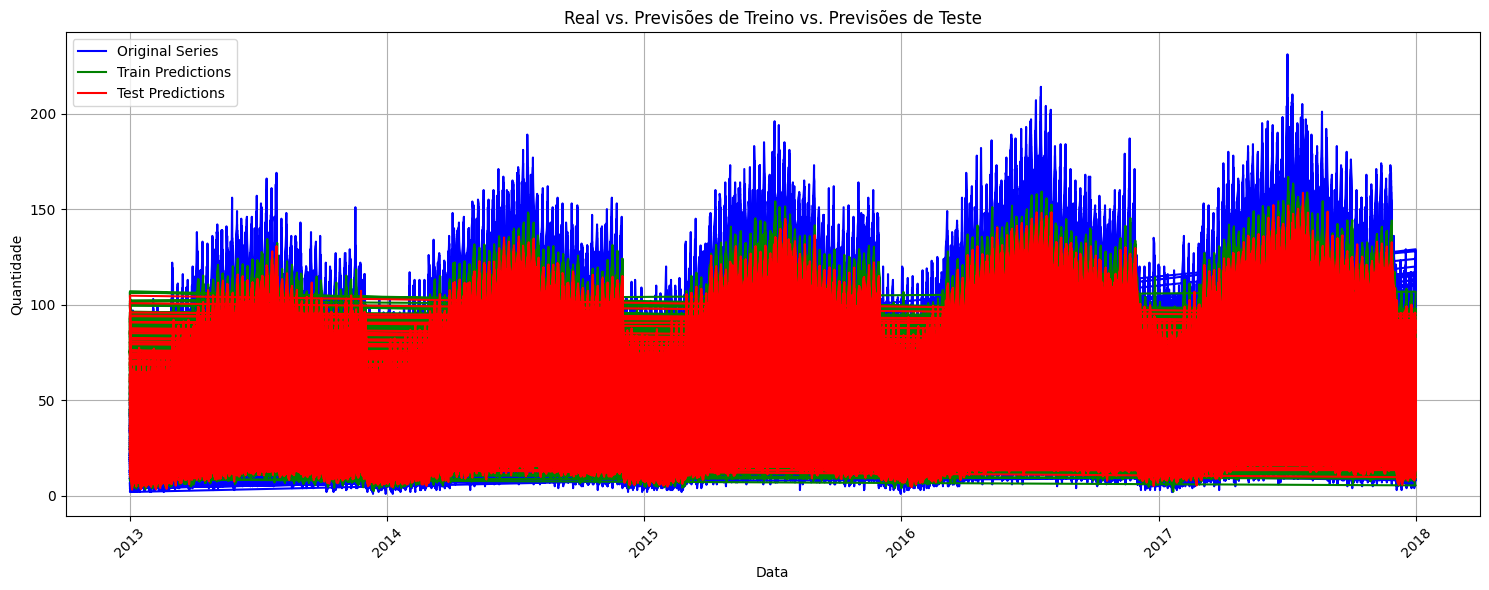

In [ ]:
def plot_predictions_with_matplotlib(dates, original_series, train_predict, test_predict, scaler, look_back):
    # Invertendo a escala para a forma original
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)

    # Preparando a estrutura para o plot
    train_plot = np.empty_like(original_series, dtype=np.float32)
    train_plot[:, :] = np.nan
    train_plot[look_back:len(train_predict)+look_back, 0] = train_predict[:, 0]

    test_plot = np.empty_like(original_series, dtype=np.float32)
    test_plot[:, :] = np.nan
    test_plot[len(train_predict)+(look_back*2)+1:len(original_series)-1, 0] = test_predict[:, 0]

    # Plotagem usando matplotlib
    plt.figure(figsize=(15, 6))
    plt.plot(dates, original_series, label='Original Series', color='blue')
    plt.plot(dates, train_plot, label='Train Predictions', color='green')
    plt.plot(dates, test_plot, label='Test Predictions', color='red')
    plt.title('Real vs. Previsões de Treino vs. Previsões de Teste')
    plt.xlabel('Data')
    plt.ylabel('Quantidade')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.xticks(rotation=45) # Rotaciona as labels do eixo x para melhor visualização.
    plt.tight_layout()
    plt.show()

# No final do código, chame a nova função de plotagem usando as datas do DataFrame original
dates = df['date'].values
plot_predictions_with_matplotlib(dates, single_series, trainPredict, testPredict, scaler, look_back)

# **7 - Previsão da demanda do produto**

In [ ]:
# Visualize os valores previstos para os próximos 7 dias
next_week_predictions = testPredict[-10:]  # Pega os últimos 10 valores de previsão

# Transforme a matriz 1D em uma matriz 2D usando reshape
next_week_predictions_2d = next_week_predictions.reshape(-1, 1)

# Inverta a transformação usando o scaler
next_week_predictions_inverse = scaler.inverse_transform(next_week_predictions_2d)

data_maxima = pd.Timestamp(data_maxima)

# Crie um DataFrame para as datas dos próximos 10 dias
next_dates = pd.date_range(start=data_maxima + pd.Timedelta(days=1), periods=10, freq='D')

# Crie um DataFrame com as datas e as previsões
next_week_df = pd.DataFrame({'Data': next_dates, 'Previsão': next_week_predictions_inverse.flatten()})

print(next_week_df)

        Data   Previsão
0 2018-01-01  51.260437
1 2018-01-02  56.423313
2 2018-01-03  64.982231
3 2018-01-04  68.294220
4 2018-01-05  72.016441
5 2018-01-06  60.632416
6 2018-01-07  49.815765
7 2018-01-08  52.867615
8 2018-01-09  55.428314
9 2018-01-10  65.716850


In [ ]:
# Buscar números histórico com base em quantidade de dias a ser informado
dias_historico = 10

# Últimos 30 dias do DataFrame original
historico = df['sales'].values[-dias_historico:]

print(historico)

[75 70 76 51 41 63 59 74 62 82]
